# IMPORTS

In [1]:
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import RTDETR

# BÚSQUEDA DE PARÁMETROS

In [2]:
MODELO = "rt-detr-l_citdet" # <----- CAMBIAR ESTO SÓLO

# --- Configuración ---
csv_path = '/home/quirogaalu/TFG/labels_regresion_det_1024.csv'
df = pd.read_csv(csv_path)

# --- Cargar modelo YOLO ---
modelo_path = f"/home/quirogaalu/TFG/models/{MODELO}.pt"
model = RTDETR(modelo_path)

# Filtrar imágenes de train y valid
df = df[df['ruta_imagen'].str.contains("train|valid", case=False, regex=True)].copy()
y_true = df['conteo_real'].values

media = y_true.mean()

# Rangos a probar
factor_range = np.linspace(0.0, 9.0, 1000)

# Resultados
resultados = []
detecciones = []

# Ejecutar YOLO y contar
for path in tqdm(df['ruta_imagen'], desc="Generando detecciones"):
    result = model(path, verbose=False, imgsz=1024)
    count = len(result[0].boxes)
    detecciones.append(count)

detecciones = np.array(detecciones)

# Paso 2: buscar el mejor factor por MAE
maes = []
for f in tqdm(factor_range, desc="Explorando"):
    estimado = detecciones * f
    mae = mean_absolute_error(y_true, estimado)
    maes.append(mae)

best_idx = np.argmin(maes)
best_f = factor_range[best_idx]
best_mae = maes[best_idx]

resultados.append({
    'factor_oclusion': round(best_f, 4),
    'mae': round(best_mae, 2)
})

# Crear DataFrame
res_df = pd.DataFrame(resultados).sort_values("mae")
print("\n✅ Mejor factor encontrado:")
print(res_df.head(1))

# Guardar
res_df.to_csv(f"/home/quirogaalu/TFG/parametros_{MODELO}.csv", index=False)

Explorando: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9496.83it/s]


✅ Mejor factor encontrado:
   factor_oclusion    mae
0            3.964  34.89


# GENERAR DETECCIONES

In [3]:
# Obtener la mejor fila (la de menor MAE)
best = res_df.iloc[0]

# Extraer los valores como variables
best_factor = best['factor_oclusion']

# --- Configuración ---
df = pd.read_csv(csv_path)

modelo_path = f"/home/quirogaalu/TFG/models/{MODELO}.pt"

# --- Cargar modelo YOLO ---
model = RTDETR(modelo_path)

# --- Filtrar sólo las imágenes de test
df = df[df.iloc[:, 0].str.contains("test", case=False)].copy()
df.rename(columns={df.columns[0]: "ruta_imagen"}, inplace=True)

# Añadir columnas para predicción
df['detecciones_visibles'] = 0
df['estimacion_total'] = 0

# --- Procesar imágenes ---
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["ruta_imagen"]
    
    try:
        results = model(img_path, verbose=False, imgsz=1024)
        detections = results[0].boxes
        num_detections = len(detections)

        df.at[idx, 'detecciones_visibles'] = num_detections

    except Exception as e:
        print(f"[!] Error al procesar {img_path}: {e}")

100%|███████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 24.44it/s]


# GENERAR PREDICCIONES

In [4]:
'''
# DETERMINAR FACTOR DE OCLUSIÓN ÓPTIMO

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Datos de entrada ---
X = df[['detecciones_visibles']].values  # matriz (n,1)
y = df['conteo_real'].values             # vector (n,)

# --- Regresión lineal sin intercepto ---
reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)

# --- Factor óptimo aprendido ---
best_factor = reg.coef_[0]
df['estimacion_total'] = df['detecciones_visibles'] * best_factor

# --- Métricas ---
mae = mean_absolute_error(y, df['estimacion_total'])
mse = mean_squared_error(y, df['estimacion_total'])
r2 = r2_score(y, df['estimacion_total'])

print(f"✅ Factor óptimo por regresión: {best_factor:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² : {r2:.3f}")
'''

'\n# DETERMINAR FACTOR DE OCLUSIÓN ÓPTIMO\n\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\n# --- Datos de entrada ---\nX = df[[\'detecciones_visibles\']].values  # matriz (n,1)\ny = df[\'conteo_real\'].values             # vector (n,)\n\n# --- Regresión lineal sin intercepto ---\nreg = LinearRegression(fit_intercept=False)\nreg.fit(X, y)\n\n# --- Factor óptimo aprendido ---\nbest_factor = reg.coef_[0]\ndf[\'estimacion_total\'] = df[\'detecciones_visibles\'] * best_factor\n\n# --- Métricas ---\nmae = mean_absolute_error(y, df[\'estimacion_total\'])\nmse = mean_squared_error(y, df[\'estimacion_total\'])\nr2 = r2_score(y, df[\'estimacion_total\'])\n\nprint(f"✅ Factor óptimo por regresión: {best_factor:.4f}")\nprint(f"MAE: {mae:.2f}")\nprint(f"MSE: {mse:.2f}")\nprint(f"R² : {r2:.3f}")\n'

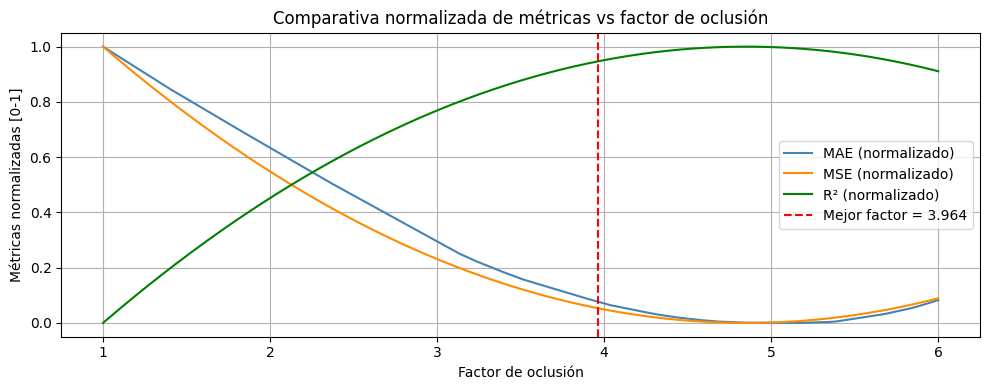

In [6]:
detecciones = df['detecciones_visibles'].values
conteo_real = df['conteo_real'].values

factors = np.linspace(1.0, 6.0, 1000)
maes = [mean_absolute_error(conteo_real, detecciones * f) for f in factors]
mses = [mean_squared_error(conteo_real, detecciones * f) for f in factors]
r2s  = [r2_score(conteo_real, detecciones * f) for f in factors]

# Normalización [0,1]
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

maes_norm = normalize(maes)
mses_norm = normalize(mses)
r2s_norm  = normalize(r2s)

# Gráfica
plt.figure(figsize=(10, 4))
plt.plot(factors, maes_norm, label="MAE (normalizado)", color='steelblue')
plt.plot(factors, mses_norm, label="MSE (normalizado)", color='darkorange')
plt.plot(factors, r2s_norm, label="R² (normalizado)", color='green')
plt.axvline(best_factor, color='red', linestyle='--', label=f"Mejor factor = {best_factor:.3f}")
plt.xlabel("Factor de oclusión")
plt.ylabel("Métricas normalizadas [0-1]")
plt.title("Comparativa normalizada de métricas vs factor de oclusión")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MAE: 46.79 | MSE: 3350.27 | R²: -0.03



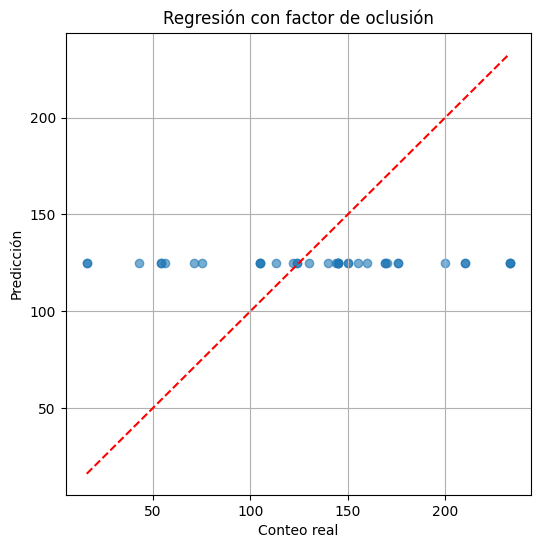

In [7]:
'''
import matplotlib.pyplot as plt

# ESTIMACION CON LA MEDIA

print(media)

df['estimacion_total'] = media

# --- Métricas ---
mae = mean_absolute_error(df['conteo_real'], df['estimacion_total'])
mse = mean_squared_error(df['conteo_real'], df['estimacion_total'])
r2 = r2_score(df['conteo_real'], df['estimacion_total'])

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}\n")

# --- Gráfico ---
plt.figure(figsize=(6, 6))
plt.scatter(df['conteo_real'], df['estimacion_total'], alpha=0.6)
plt.plot([df['conteo_real'].min(), df['conteo_real'].max()], [df['conteo_real'].min(), df['conteo_real'].max()], 'r--')
plt.xlabel('Conteo real')
plt.ylabel('Predicción')
plt.title('Regresión con factor de oclusión')
plt.grid(True)
plt.show()
'''

✅ Resultados guardados en: /home/quirogaalu/TFG/predicciones_rt-detr-l_citdet.csv

MAE: 46.11 | MSE: 3230.65 | R²: 0.01



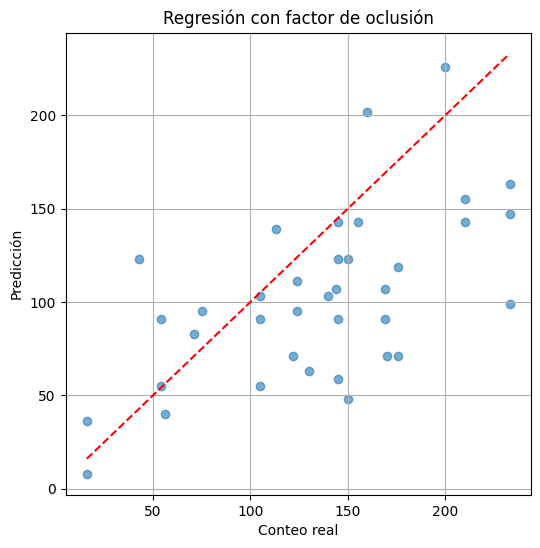

In [5]:
import matplotlib.pyplot as plt

# --- Guardar predicciones ---
df['estimacion_total'] = (df['detecciones_visibles'] * best_factor).round().astype(int)

# --- Guardar resultados ---
output_csv = f"/home/quirogaalu/TFG/predicciones_{MODELO}.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Resultados guardados en: {output_csv}\n")

# --- Métricas ---
mae = mean_absolute_error(df['conteo_real'], df['estimacion_total'])
mse = mean_squared_error(df['conteo_real'], df['estimacion_total'])
r2 = r2_score(df['conteo_real'], df['estimacion_total'])

print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | R²: {r2:.2f}\n")

# --- Gráfico ---
plt.figure(figsize=(6, 6))
plt.scatter(df['conteo_real'], df['estimacion_total'], alpha=0.6)
plt.plot([df['conteo_real'].min(), df['conteo_real'].max()], [df['conteo_real'].min(), df['conteo_real'].max()], 'r--')
plt.xlabel('Conteo real')
plt.ylabel('Predicción')
plt.title('Regresión con factor de oclusión')
plt.grid(True)
plt.show()

# ANÁLISIS DE LOS ERRORES

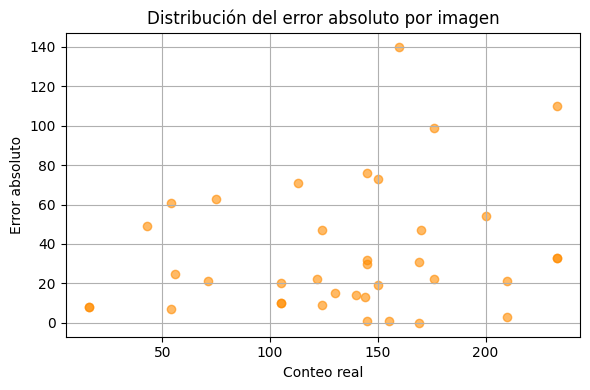

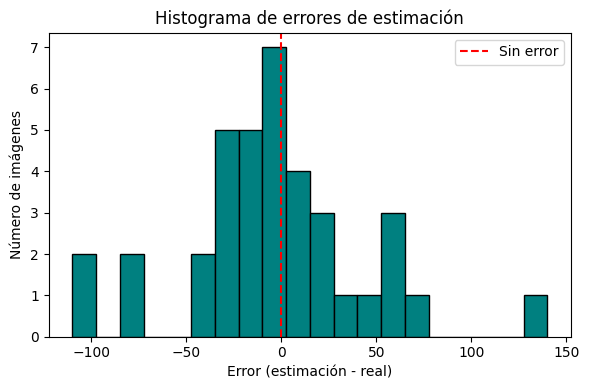

In [14]:
errors = abs(df['estimacion_total'] - df['conteo_real'])

plt.figure(figsize=(6, 4))
plt.scatter(df['conteo_real'], errors, alpha=0.6, color='darkorange')
plt.xlabel('Conteo real')
plt.ylabel('Error absoluto')
plt.title('Distribución del error absoluto por imagen')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------

residuos = df['estimacion_total'] - df['conteo_real']

plt.figure(figsize=(6, 4))
plt.hist(residuos, bins=20, color='teal', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Sin error')
plt.xlabel('Error (estimación - real)')
plt.ylabel('Número de imágenes')
plt.title('Histograma de errores de estimación')
plt.legend()
plt.tight_layout()
plt.show()